## 1. Introduction

#### 1.1 Background Information

According to Deloitte Digital (2015), digital interactions are expected to influence 64 cents
of every dollar spent in retail stores by the end of 2015, meaning that social media is increasing its direct impact on companies' revenues. Combined that with the acceleration of social media use in the pandemic, it's key for companies to understand what will engage consumers the most. 

Therefore, we will compare average Lifetime Post Consumptions/Lifetime Post Total Impressions ratio between different types of content (Status, Photo, Link, Video) and find out if there is a statistical difference between them. The idea being we want to see how effective each type of content is when converting looks into engagement.

#### 1.2 Dataset Description

The dataset is a compilation of 500 different facebook posts by cosmetics brand. Each observation includes important information on the post including the following variables of interest for this report:

- Type: The type of facebook post (Video, Photo etc).
- Lifetime Impressions: This is the number of times the post is displayed. For example on a news feed or different page. The post does not have to be clicked to count as an impression.
- Lifetime Consumptions: This is the total number of clicks on the post.

## 2. Preliminary Results

#### 2.1 Reading the Data

In [3]:
# Load the required libraries
library(tidyverse)
library(cowplot)
library(digest)
library(gridExtra)
library(infer)
library(repr)
library(tidyverse)
set.seed(1)

# Here we read the data set straight from the web
# The original source is linked here (https://archive.ics.uci.edu/ml/datasets/Facebook+metrics)
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip",temp)
data <- read_delim(unz(temp, "dataset_Facebook.csv"), delim=";")
unlink(temp)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Rows: 500 Columns: 19

── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr  (1): Type
dbl (18): Page total likes, Category, Post Month, Post Weekday, Post Hour, P...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



#### 2.2 Cleaning the Data

In [4]:
# First remove spaces from the column names
names(data)<-make.names(names(data),unique = TRUE)

# Select only the variables of interest
data_selected = data %>%
    select(Type, Lifetime.Post.Total.Impressions, Lifetime.Post.Consumptions) %>%
    mutate(ratio=Lifetime.Post.Consumptions/Lifetime.Post.Total.Impressions) %>%
    filter(!is.na(Type))

# Assign new more manageable column names
names(data_selected) <- c("Type", "LifetimeImpressions", "LifetimeConsumptions", "ConsumptionsOverImpressions")

# Here we break the dataset apart by type for later use
data_photo = data_selected %>%
    filter(Type == "Photo")
data_status = data_selected %>%
    filter(Type == "Status")
data_link = data_selected %>%
    filter(Type == "Link")
data_video = data_selected %>%
    filter(Type == "Video")

# Preview the clean dataset
head(data_selected)

Type,LifetimeImpressions,LifetimeConsumptions,ConsumptionsOverImpressions
<chr>,<dbl>,<dbl>,<dbl>
Photo,5091,159,0.03123159
Status,19057,1674,0.08784174
Photo,4373,154,0.03521610
Photo,87991,1119,0.01271721
Photo,13594,580,0.04266588
Status,20849,1389,0.06662190


#### 2.3 Data Summary

In [5]:
# Here we will provide a summary of the dataset
data_summary <- data_selected %>%
    group_by(Type) %>%
    summarise(MeanImpressions = mean(LifetimeImpressions), MinImpressions = min(LifetimeImpressions),
              MaxImpressions = max(LifetimeImpressions),  MeanConsumptions = mean(LifetimeConsumptions),
              MinConsumptions = min(LifetimeConsumptions), MaxConsumptions = max(LifetimeConsumptions), 
              MeanRatio = mean(ConsumptionsOverImpressions), Num = sum(Type == Type))
data_summary

data_summary_longer <- data_summary %>%
    select(Type, MeanImpressions, MeanConsumptions) %>%
    pivot_longer(cols=c('MeanImpressions', 'MeanConsumptions'), names_to='variable', values_to='value')

data_summary_longer

Type,MeanImpressions,MinImpressions,MaxImpressions,MeanConsumptions,MinConsumptions,MaxConsumptions,MeanRatio,Num
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Link,28725.45,3094,229733,374.0909,26,1345,0.02594883,22
Photo,28994.50,570,1110282,1299.0258,9,19779,0.12364624,426
Status,24244.47,7509,59964,2838.8667,112,9237,0.10865636,45
Video,102622.43,30235,277100,2600.1429,539,7327,0.04637671,7


Type,variable,value
<chr>,<chr>,<dbl>
Link,MeanImpressions,28725.4545
Link,MeanConsumptions,374.0909
Photo,MeanImpressions,28994.4977
Photo,MeanConsumptions,1299.0258
Status,MeanImpressions,24244.4667
Status,MeanConsumptions,2838.8667
Video,MeanImpressions,102622.4286
Video,MeanConsumptions,2600.1429


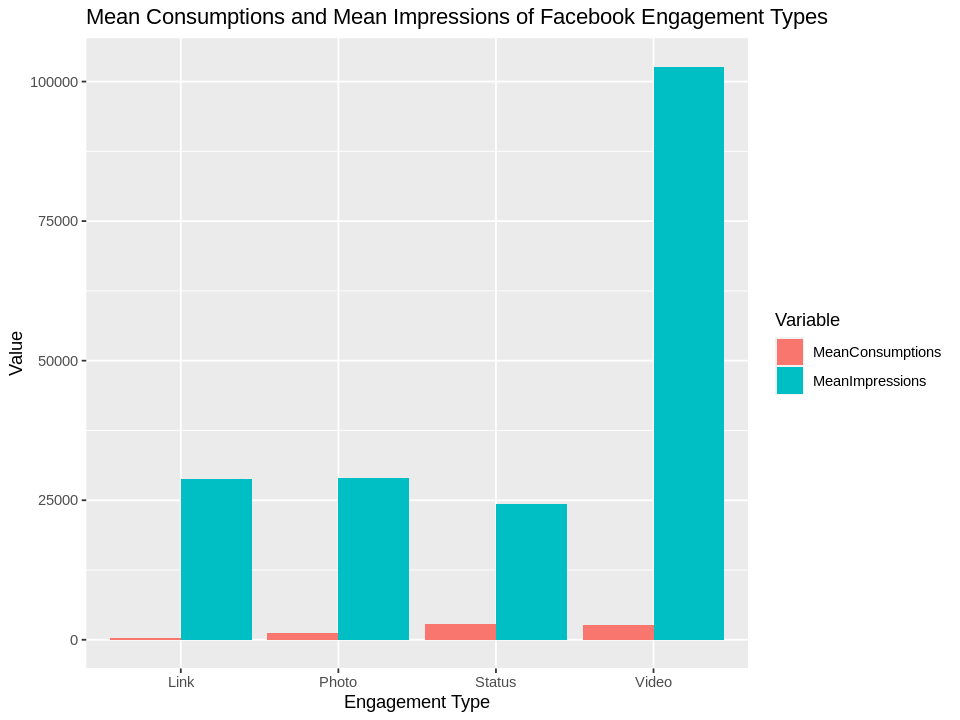

In [6]:
options(repr.plot.width = 8, repr.plot.height = 6)

data_summary_plot <- data_summary_longer %>%
    ggplot(aes(x=Type, y=value, fill=variable)) +
    geom_bar(stat='identity', position='dodge') +
    labs(x = "Engagement Type", y = "Value", fill = "Variable") +
    ggtitle("Mean Consumptions and Mean Impressions of Facebook Engagement Types")
data_summary_plot

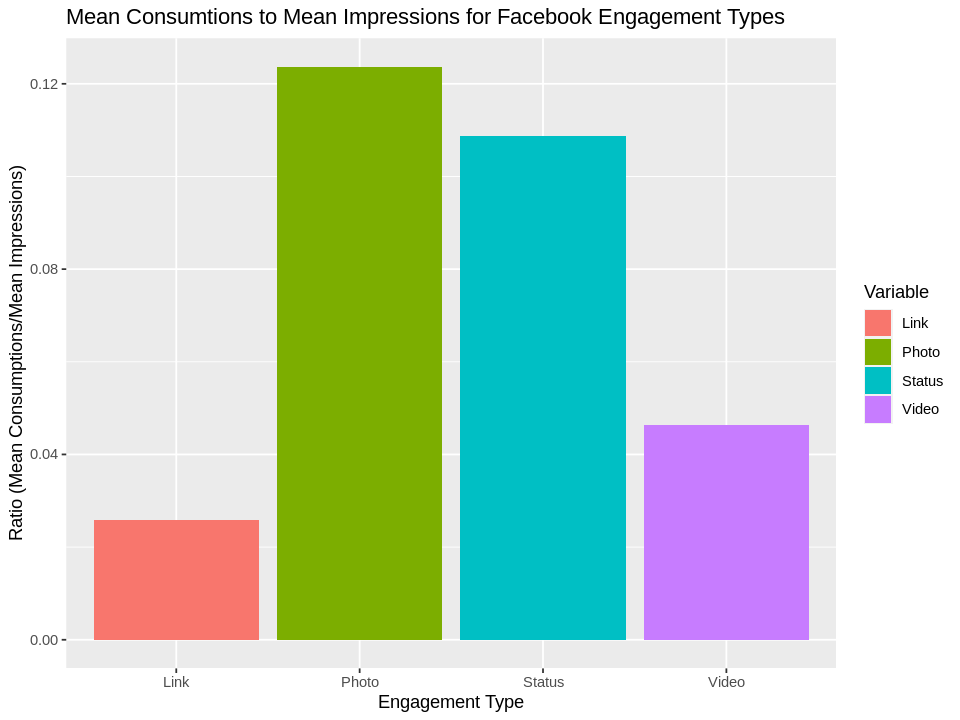

In [7]:
options(repr.plot.width = 8, repr.plot.height = 6)
data_ratio_plot <- data_summary %>%
    ggplot(aes(x=Type, y=MeanRatio, fill=Type)) +
    geom_bar(stat='identity', position='dodge') + 
    labs(x = "Engagement Type", y = "Ratio (Mean Consumptions/Mean Impressions)", fill = "Variable") +
    ggtitle("Mean Consumtions to Mean Impressions for Facebook Engagement Types")
data_ratio_plot

#### 2.4 Plot Observations

In the side by side plot of mean impressions and mean consumptions as expected the impressions far outweigh the consumptions. This means on average facebook displays a post far more often than that post gets clicked. Another key insight is that Videos seem to be shared a lot more across facebook as their mean impressions are by far the highest.

The second plot which compares the ratios shows a higher ratio for both Link and Video. This means that it takes a higher number of impressions for both Link and Video posts per consumption. TODO: maybe add some more to this paragraph explaining the plots

#### 2.5 Bootstraping

In [19]:
# Below we take a bootstrap of 1000 resamples for each type of post (Photo, Video, etc.) The sizes were precalculated in the main summary
# table and were used again.

bootstrap_photo <- data_photo %>% 
    rep_sample_n(reps = 1000, size = 426, replace = TRUE) %>% 
    group_by(replicate) %>% 
    summarize(mean_ratio = mean(ConsumptionsOverImpressions)) %>% 
    select(mean_ratio)

bootstrap_status <- data_status %>% 
    rep_sample_n(reps = 1000, size = 45, replace = TRUE) %>% 
    group_by(replicate) %>% 
    summarize(mean_ratio = mean(ConsumptionsOverImpressions)) %>% 
    select(mean_ratio)

bootstrap_video <- data_video %>% 
    rep_sample_n(reps = 1000, size = 7, replace = TRUE) %>% 
    group_by(replicate) %>% 
    summarize(mean_ratio = mean(ConsumptionsOverImpressions)) %>% 
    select(mean_ratio)

bootstrap_link <- data_link %>% 
    rep_sample_n(reps = 1000, size = 22, replace = TRUE) %>% 
    group_by(replicate) %>% 
    summarize(mean_ratio = mean(ConsumptionsOverImpressions)) %>% 
    select(mean_ratio)

Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


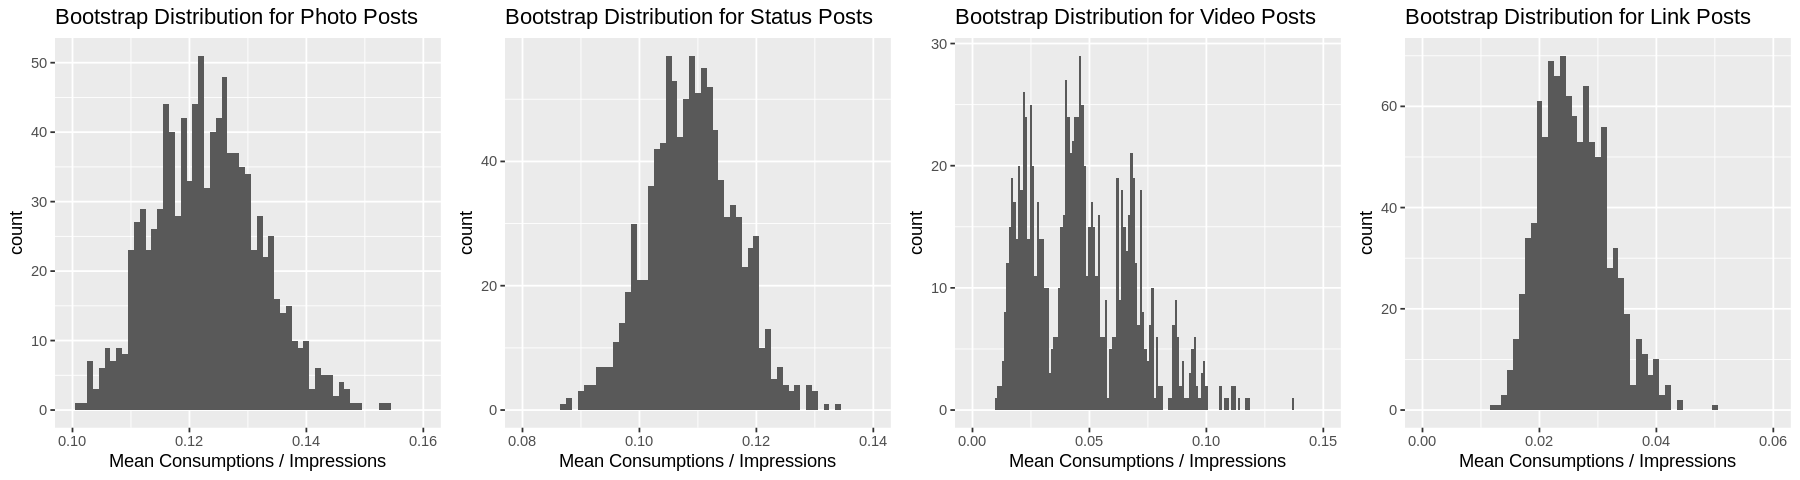

In [45]:
options(repr.plot.width = 15, repr.plot.height = 4)

# in this cell we will plot all bootstrap distributions to get an idea of the originial distributions
bootstrap_photo_plot <- bootstrap_photo %>%
    ggplot(aes(x = mean_ratio)) +
    geom_histogram(binwidth = 0.001) +
    xlab("Mean Consumptions / Impressions")

bootstrap_status_plot <- bootstrap_status %>%
    ggplot(aes(x = mean_ratio)) +
    geom_histogram(binwidth = 0.001) +
    xlab("Mean Consumptions / Impressions")

bootstrap_video_plot <- bootstrap_video %>%
    ggplot(aes(x = mean_ratio)) +
    geom_histogram(binwidth = 0.001) +
    xlab("Mean Consumptions / Impressions")

bootstrap_link_plot <- bootstrap_link %>%
    ggplot(aes(x = mean_ratio)) +
    geom_histogram(binwidth = 0.001) +
    xlab("Mean Consumptions / Impressions")

# Plot the bootstrap distributions side by side
plot_grid(bootstrap_photo_plot +
              labs(title = "Bootstrap Distribution for Photo Posts") +
              scale_x_continuous(limits = c(0.1,0.16)),
          bootstrap_status_plot +
              labs(title = "Bootstrap Distribution for Status Posts") +
              scale_x_continuous(limits = c(0.08,0.14)),
          bootstrap_video_plot +
              labs(title = "Bootstrap Distribution for Video Posts") +
              scale_x_continuous(limits = c(0,0.15)),
          bootstrap_link_plot +
              labs(title = "Bootstrap Distribution for Link Posts") +
              scale_x_continuous(limits = c(0,0.06)),
          ncol = 4)

In [10]:
# In this cell we calculate the 90% confidence interval for the original means using the bootstraps calculated previously

# Combine all bootstraps to one DF and calculate confidence intervals
Confidence_Interval <- bind_rows(mutate(bootstrap_photo, Type = "Photo"),
    mutate(bootstrap_status, Type = "Status"),
    mutate(bootstrap_video, Type = "Video"),
    mutate(bootstrap_link, Type = "Link")) %>%
    group_by(Type) %>%
    summarise(ci_lower = quantile(mean_ratio, 0.05),
              ci_upper = quantile(mean_ratio, 0.95)) %>%
    bind_cols(select(data_summary, MeanRatio))

Confidence_Interval


Type,ci_lower,ci_upper,MeanRatio
<chr>,<dbl>,<dbl>,<dbl>
Link,0.01751523,0.03580021,0.02594883
Photo,0.10876724,0.13981007,0.12364624
Status,0.09639651,0.12061863,0.10865636
Video,0.01697675,0.08688191,0.04637671


TODO: Add brief interpretation of the confidence intervals above

## 3. Methods

   Our group plan to analyze the ratios of the averages of Lifetime Post Consumptions/Lifetime Post Total Impressions between the following types of content, including Status, Photo, Link and Video. Evaluating the impact of advertisement in social media is a critical problem in commercial strategy, the ratio that we are concerned with is exactly related to it (Moro et al., 2016). We plan to use the method of bootstrapping to get the sample’s average since we cannot get the population parameter. The above histograms represent these four significant factors that can contribute to influencing the ratio of the two variables that we are concerned about. To make our report trustworthy, we also going to construct and visualize the confidence intervals to determine if they will capture the true values. However, the plots and estimates are not enough to give to a stakeholder, hypothesis testing is going to be used to address this gap, which can assess the plausibility of a hypothesis by using sample data, making our statistical inference more reliable and accurate.

   Using the methods above, the graphs of each of the variables can give us information about the four averages of Lifetime Post Consumptions/Lifetime Post Total Impressions ratio. Comparing them can help understand their relationships between the content types (Status, Photo, Link, Video) and this ratio, which can provide useful and valuable information when the companies advertise their products on social media. They may determine which types of content should be posted based on the results of our research. Our research can lead to a future question which is if our results will be influenced by different types of products, such as clothes, food, education, and so on.

## 4. References

1. Moro, S., Rita, P., & Vala, B. (2016). Predicting social media performance metrics and evaluation of the impact on brand building: A data mining approach. Journal of Business Research, 69(9), 3341-3351. https://doi.org/10.1016/j.jbusres.2016.02.010 
